In [1]:
import numpy as np
import tensorflow as tf

In [2]:
test_data = np.load('/users/jhlee/data/img_snd/test_data.npz')
validation_data = np.load('/users/jhlee/data/img_snd/validation_data.npz')

img_dim = (99, 257)

In [3]:
X_train = test_data['X_test']
y_train = test_data['y_test']
X_valid = validation_data['X_validation']
y_valid = validation_data['y_validation']

In [4]:
X_tr = X_train.reshape(-1, img_dim[0], img_dim[1])

In [5]:
import matplotlib.pyplot as plt

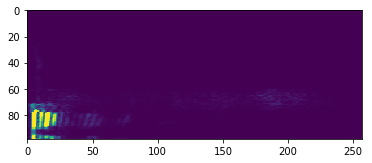

In [18]:
plt.figure()
plt.imshow(X_train[0].reshape(99,257))

In [6]:
plt.figure()
plt.imshow(X_tr[5])

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

In [12]:
def batch_generator(X, y, batch_size=64, 
                    shuffle=False, random_seed=None):
    
    idx = np.arange(y.shape[0])
    
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

In [18]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((4815, 25443), (4815,), (4293, 25443), (4293,))

In [19]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
#X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_valid #, X_test

In [21]:
## wrapper functions 

def conv_layer(input_tensor, name,
               kernel_size, n_output_channels, 
               padding_mode='SAME', strides=(1, 1, 1, 1)):
    with tf.variable_scope(name):
        ## get n_input_channels:
        ##   input tensor shape: 
        ##   [batch x width x height x channels_in]
        input_shape = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1] 

        weights_shape = (list(kernel_size) + 
                         [n_input_channels, n_output_channels])

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_channels]))
        print(biases)
        conv = tf.nn.conv2d(input=input_tensor, 
                            filter=weights,
                            strides=strides, 
                            padding=padding_mode)
        print(conv)
        conv = tf.nn.bias_add(conv, biases, 
                              name='net_pre-activation')
        print(conv)
        conv = tf.nn.relu(conv, name='activation')
        print(conv)
        
        return conv
    

## testing
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None, img_dim[0], img_dim[1], 1])
    conv_layer(x, name='convtest', kernel_size=(3, 3), n_output_channels=32)
    
del g, x

<tf.Variable 'convtest/_weights:0' shape=(3, 3, 1, 32) dtype=float32_ref>
<tf.Variable 'convtest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("convtest/Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/net_pre-activation:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/activation:0", shape=(?, 28, 28, 32), dtype=float32)


In [35]:
def fc_layer(input_tensor, name, 
             n_output_units, activation_fn=None):
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor, 
                                      shape=(-1, n_input_units))

        weights_shape = [n_input_units, n_output_units]

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_units]))
        print(biases)
        layer = tf.matmul(input_tensor, weights)
        print(layer)
        layer = tf.nn.bias_add(layer, biases,
                              name='net_pre-activation')
        print(layer)
        if activation_fn is None:
            return layer
        
        layer = activation_fn(layer, name='activation')
        print(layer)
        return layer

    
## testing:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, 
                       shape=[None, 28, 28, 1])
    fc_layer(x, name='fctest', n_output_units=32, 
             activation_fn=tf.nn.relu)
    
del g, x

<tf.Variable 'fctest/_weights:0' shape=(784, 32) dtype=float32_ref>
<tf.Variable 'fctest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("fctest/MatMul:0", shape=(?, 32), dtype=float32)
Tensor("fctest/net_pre-activation:0", shape=(?, 32), dtype=float32)
Tensor("fctest/activation:0", shape=(?, 32), dtype=float32)


In [36]:
type(np.prod(img_dim))

numpy.int64

In [44]:
def build_cnn():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, np.prod(img_dim)],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, img_dim[0], img_dim[1], 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=16,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    h1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5), 
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling
    h1_pool = tf.nn.max_pool(h1, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    h2 = conv_layer(h1_pool, name='conv_2', 
                    kernel_size=(5,5), 
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    h2_pool = tf.nn.max_pool(h2, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')

    ## 3rd layer: Fully Connected
    print('\nBuilding 3rd layer:')
    h3 = fc_layer(h2_pool, name='fc_3',
                  n_output_units=1024, 
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    h3_drop = tf.nn.dropout(h3, keep_prob=keep_prob, 
                            name='dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    h4 = fc_layer(h3_drop, name='fc_4',
                  n_output_units=16, 
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(h4, name='probabilities'),
        'labels' : tf.cast(tf.argmax(h4, axis=1), tf.int32,
                           name='labels')
    }
    
    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=h4, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'], 
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')

    
def save(saver, sess, epoch, path='./model/'):
    if not os.path.isdir(path):
        os.makedirs(path)
    print('Saving model in %s' % path)
    saver.save(sess, os.path.join(path,'cnn-model.ckpt'),
               global_step=epoch)

    
def load(saver, sess, path, epoch):
    print('Loading model from %s' % path)
    saver.restore(sess, os.path.join(
            path, 'cnn-model.ckpt-%d' % epoch))

    
def train(sess, training_set, validation_set=None,
          initialize=True, epochs=20, shuffle=True,
          dropout=0.5, random_seed=None):

    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])
    training_loss = []

    ## initialize variables
    if initialize:
        sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed) # for shuflling in batch_generator
    for epoch in range(1, epochs+1):
        batch_gen = batch_generator(
                        X_data, y_data, batch_size=1, 
                        shuffle=shuffle)
        avg_loss = 0.0
        for i,(batch_x,batch_y) in enumerate(batch_gen):
            feed = {'tf_x:0': batch_x, 
                    'tf_y:0': batch_y, 
                    'fc_keep_prob:0': dropout}
            loss, _ = sess.run(
                    ['cross_entropy_loss:0', 'train_op'],
                    feed_dict=feed)
            avg_loss += loss

        training_loss.append(avg_loss / (i+1))
        print('Epoch %02d Training Avg. Loss: %7.3f' % (
            epoch, avg_loss), end=' ')
        if validation_set is not None:
            feed = {'tf_x:0': validation_set[0],
                    'tf_y:0': validation_set[1],
                    'fc_keep_prob:0':1.0}
            valid_acc = sess.run('accuracy:0', feed_dict=feed)
            print(' Validation Acc: %7.3f' % valid_acc)
        else:
            print()

            
def predict(sess, X_test, return_proba=False):
    feed = {'tf_x:0': X_test, 
            'fc_keep_prob:0': 1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict=feed)
    else:
        return sess.run('labels:0', feed_dict=feed)

In [45]:
## Define hyperparameters
learning_rate = 1e-4
random_seed = 123

np.random.seed(random_seed)


## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn()

    ## saver:
    saver = tf.train.Saver()


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 95, 253, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 95, 253, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 95, 253, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 44, 123, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 44, 123, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 44, 123, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(87296, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), 

In [46]:
## crearte a TF session 
## and train the CNN model

with tf.Session(graph=g) as sess:
    train(sess, 
          training_set=(X_train_centered, y_train), 
          validation_set=(X_valid_centered, y_valid), 
          initialize=True,
          random_seed=123, epochs=3)
    save(saver, sess, epoch=3)

ResourceExhaustedError: OOM when allocating tensor of shape [87296,1024] and type float
	 [[Node: fc_3/_weights/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [87296,1024] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'fc_3/_weights/Adam/Initializer/zeros', defined at:
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-08723f032ee7>", line 13, in <module>
    build_cnn()
  File "<ipython-input-44-a9483eaaa2eb>", line 75, in build_cnn
    name='train_op')
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 410, in minimize
    name=name)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 588, in apply_gradients
    self._create_slots(var_list)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 134, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 1134, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 181, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 155, in create_slot_with_initializer
    dtype)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1467, in get_variable
    aggregation=aggregation)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1217, in get_variable
    aggregation=aggregation)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 527, in get_variable
    aggregation=aggregation)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 481, in _true_getter
    aggregation=aggregation)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 903, in _get_single_variable
    aggregation=aggregation)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2443, in variable
    aggregation=aggregation)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2425, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2406, in default_variable_creator
    constraint=constraint)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __init__
    constraint=constraint)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 368, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 885, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py", line 100, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1551, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2794, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/jhlee/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [87296,1024] and type float
	 [[Node: fc_3/_weights/Adam/Initializer/zeros = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [87296,1024] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
